In [1]:
from yaml import safe_load
from itertools import product
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
import scienceplots

from einops import rearrange
from typing import Any

plt.style.use('science')

warnings.filterwarnings("ignore")

In [2]:
def infer_dataset(config: dict[str, Any]) -> str:
    datamodule = config["datamodule"]["_target_"]
    if "ECG" in datamodule:
        return "ECG"
    if "MIMICIII" in datamodule:
        return "MIMIC-III"
    if "NASDAQ" in datamodule:
        return "NASDAQ-2019"
    if "Droughts" in datamodule:
        return "US-Droughts"
    if "NASA" in datamodule:
        if config["datamodule"]["subdataset"] == "charge":
            return "NASA-Charge"
        else:
            return "NASA-Discharge"


def infer_diffusion_domain(config: dict[str, Any]) -> str:
    fourier_transform = config["fourier_transform"]
    if fourier_transform:
        return "Frequency"
    else:
        return "Time"


def calculate_metrics(results: dict) -> list[dict]:
    data = []
    for domain, method in product({"time", "freq"}, {"sliced", "marginal"}):
        all_distances = results[f"{domain}_{method}_wasserstein_all"]
        data.extend(
            [
                {
                    "Value": distance,
                    "Metric Domain": "Frequency" if domain == "freq" else "Time",
                    "Metric": "Sliced Wasserstein"
                    if method == "sliced"
                    else "Marginal Wasserstein",
                }
                for distance in all_distances
            ]
        )
    return data

def calculate_baselines(results: dict) -> list[dict]:
    data = []
    for baseline, domain, method in product({"dummy", "self"}, {"time", "freq"}, {"sliced", "marginal"}):
        distance = results[f"{domain}_{method}_wasserstein_mean_{baseline}"]
        data.append(
                {
                    "Value": distance,
                    "Baseline": "Mean" if baseline == "dummy" else "Half Train",
                    "Metric Domain": "Frequency" if domain == "freq" else "Time",
                    "Metric": "Sliced Wasserstein"
                    if method == "sliced"
                    else "Marginal Wasserstein",
                } 
        )
    return data


def infer_tensor_shapes(sample_path: Path) -> tuple[int, int]:
    samples = torch.load(sample_path)
    return samples.shape[-2:]


def calculate_spectral_density(
    marginal_spectral: list[float], sample_path: Path
) -> list[float]:
    _, n_channels = infer_tensor_shapes(sample_path)
    marginal_spectral = torch.tensor(marginal_spectral)
    marginal_spectral = rearrange(
        marginal_spectral, "(freq channels) -> freq channels", channels=n_channels
    )
    return marginal_spectral.mean(dim=1)

In [3]:
run_list = [
    "wdwxc4fg",
    "amxdfaoo",
    "20d9c1kc",
    "j5l1t49d",
    "tip2g8eh",
    "pkjeomys",
    "qdzk36m7",
    "hxoxvper",
    "xxqse6xu",
    "na9xdfui",
    "bf3lrfx9",
    "emk7nyz3",
]
runs_dir = Path.cwd() / "../lightning_logs/"
save_dir = Path.cwd() / "../outputs/"

if not (save_dir / "figures").exists():
    (save_dir / "figures").mkdir(parents=True)    
if not (save_dir / "tables").exists():
    (save_dir / "tables").mkdir(parents=True)    

# Sample Quality


In [4]:
df_list = []
baselines_list = []
for run in run_list:
    with open(runs_dir / f"{run}/train_config.yaml", "r") as f:
        config = safe_load(f)
        dataset = infer_dataset(config)
        domain = infer_diffusion_domain(config)
    with open(runs_dir / f"{run}/results.yaml", "r") as f:
        results = safe_load(f)
        df = pd.DataFrame(calculate_metrics(results))
        df_baselines = pd.DataFrame(calculate_baselines(results))
        df["Dataset"] = dataset
        df["Diffusion Domain"] = domain
        df_baselines["Dataset"] = dataset
        df_baselines["Diffusion Domain"] = domain
        df_list.append(df)
        baselines_list.append(df_baselines)
df = pd.concat(df_list)
df_baselines = pd.concat(baselines_list)
df.head()

,Value,Metric Domain,Metric,Dataset,Diffusion Domain
0,0.205126,Time,Sliced Wasserstein,MIMIC-III,Frequency
1,0.110730,Time,Sliced Wasserstein,MIMIC-III,Frequency
2,0.158600,Time,Sliced Wasserstein,MIMIC-III,Frequency
3,0.142727,Time,Sliced Wasserstein,MIMIC-III,Frequency
4,0.075877,Time,Sliced Wasserstein,MIMIC-III,Frequency


In [5]:
df_baselines.head()

,Value,Baseline,Metric Domain,Metric,Dataset,Diffusion Domain
0,0.880692,Mean,Time,Sliced Wasserstein,MIMIC-III,Frequency
1,0.880029,Mean,Time,Marginal Wasserstein,MIMIC-III,Frequency
2,0.834974,Mean,Frequency,Sliced Wasserstein,MIMIC-III,Frequency
3,0.366713,Mean,Frequency,Marginal Wasserstein,MIMIC-III,Frequency
4,0.159241,Half Train,Time,Sliced Wasserstein,MIMIC-III,Frequency


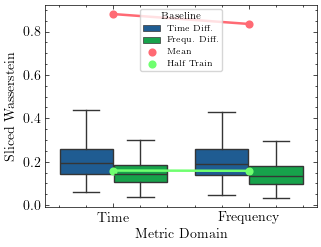

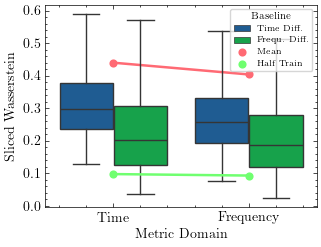

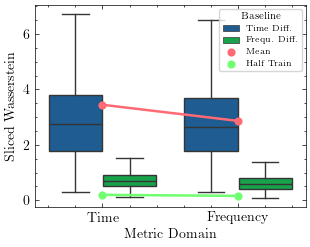

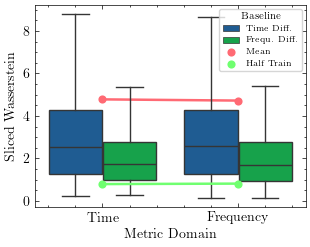

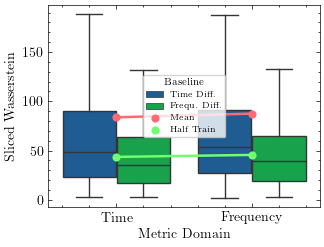

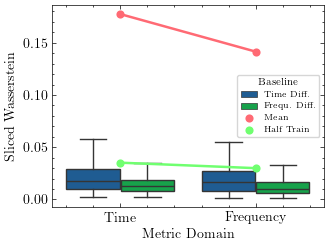

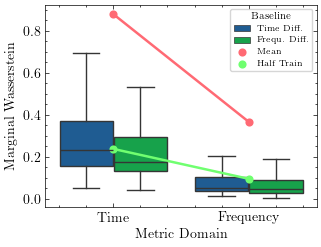

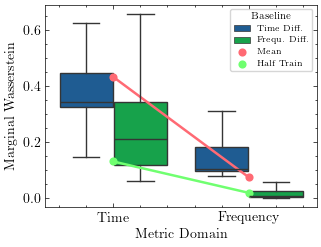

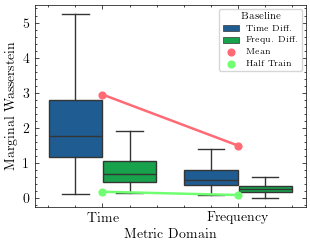

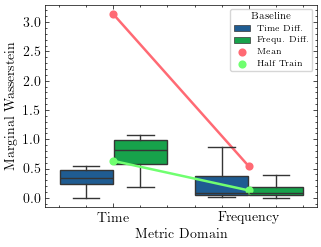

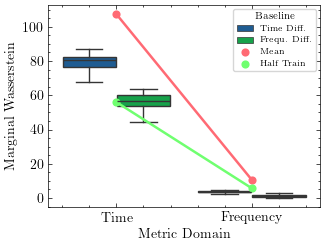

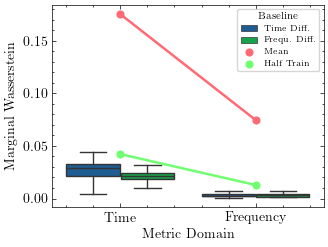

In [14]:
with plt.style.context('science'):
    for metric in df.Metric.unique():
        for dataset in df.Dataset.unique():
            df_sub = df[(df.Metric == metric) & (df.Dataset == dataset)]
            df_sub["Baseline"] = df_sub["Diffusion Domain"].apply(lambda x: "Time Diff." if x == "Time" else "Frequ. Diff.")
            ax = sns.boxplot(
                data=df_sub,
                x="Metric Domain",
                y="Value",
                hue="Baseline",
                hue_order=["Time Diff.", "Frequ. Diff."],
                showfliers=False,
            )
            sns.pointplot(data=df_baselines[(df_baselines.Metric == metric) & (df_baselines.Dataset == dataset)],
                        y="Value",
                        x="Metric Domain",
                        hue="Baseline",
                        hue_order=["Mean", "Half Train"],
                        palette=["#FF6A74", "#70ff70"],
                        ax=ax)
            plt.ylabel(metric)
            plt.legend(fontsize=6, title="Baseline", frameon=True, title_fontsize=7)
            plt.savefig(save_dir / f"figures/{metric.lower()}_{dataset.lower()}.pdf")
            plt.show()
            plt.close()

In [7]:
df_pivot = pd.pivot_table(
    df[df["Metric"] == "Sliced Wasserstein"],
    index=["Dataset", "Metric Domain", ],
    columns="Diffusion Domain",
    values="Value",
    aggfunc=["mean", "sem"],
)
df_pivot = round(df_pivot, 3)
df_pivot = "$" + df_pivot["mean"].astype(str) + " \ \pm \ " + (2 * df_pivot["sem"]).astype(str) + "$"
df_pivot.to_latex(save_dir / "tables/sliced_wasserstein.tex")
df_pivot.head()

Diffusion Domain                       Frequency                   Time
Dataset     Metric Domain                                              
ECG         Frequency        $0.012 \ \pm \ 0.0$     $0.02 \ \pm \ 0.0$
            Time             $0.015 \ \pm \ 0.0$    $0.021 \ \pm \ 0.0$
MIMIC-III   Frequency      $0.144 \ \pm \ 0.004$  $0.206 \ \pm \ 0.006$
            Time           $0.152 \ \pm \ 0.004$  $0.211 \ \pm \ 0.006$
NASA-Charge Frequency      $0.211 \ \pm \ 0.008$   $0.27 \ \pm \ 0.006$

# Spectral Analysis


In [8]:
spectral_data = []
for run in run_list:
    with open(runs_dir / f"{run}/train_config.yaml", "r") as f:
        config = safe_load(f)
        dataset_name = infer_dataset(config)
        diffusion_domain = infer_diffusion_domain(config)
    with open(runs_dir / f"{run}/results.yaml", "r") as f:
        results = safe_load(f)
        spectral_density = calculate_spectral_density(
            results["spectral_marginal_wasserstein_all"],
            sample_path=runs_dir / f"{run}/samples.pt",
        )
        freqs = torch.arange(0, 1, 1 / spectral_density.shape[0])
        spectral_data.extend(
            [
                {
                    "Dataset": dataset_name,
                    "Diffusion Domain": diffusion_domain,
                    "Frequency": freqs[k].item(),
                    "Spectral Density": spectral_density[k].item(),
                }
                for k in range(len(spectral_density))
            ]
        )
spectral_df = pd.DataFrame(spectral_data)
spectral_df.head()

,Dataset,Diffusion Domain,Frequency,Spectral Density
0,MIMIC-III,Frequency,0.000000,134.392731
1,MIMIC-III,Frequency,0.076923,8.906826
2,MIMIC-III,Frequency,0.153846,1.886092
3,MIMIC-III,Frequency,0.230769,0.968898
4,MIMIC-III,Frequency,0.307692,0.703204


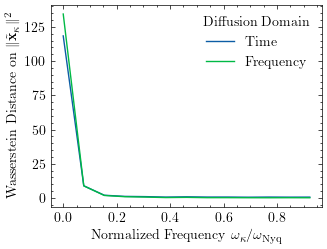

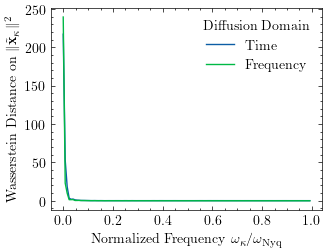

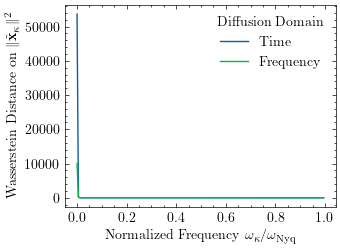

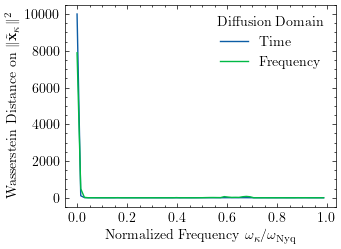

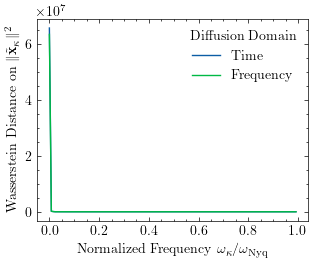

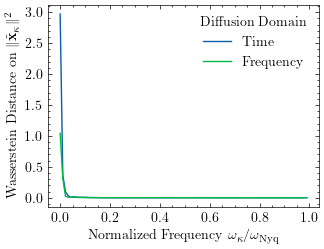

In [16]:
for dataset in spectral_df.Dataset.unique():
    ax = sns.lineplot(
        data=spectral_df[spectral_df.Dataset == dataset],
        x="Frequency",
        y="Spectral Density",
        hue="Diffusion Domain",
        hue_order=["Time", "Frequency"],
    )
    plt.ylabel(r"Wasserstein Distance on $\|\tilde{\mathbf{x}}_\kappa \|^2$")
    plt.xlabel(r"Normalized Frequency $\omega_\kappa  /  \omega_{\mathrm{Nyq}}$")
    plt.savefig(save_dir / f"figures/spectral_density_{dataset.lower()}.pdf")
    plt.show()